In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from skimage import img_as_ubyte
import traceback 
import random
from skimage.transform import resize
import logging
from PIL import Image
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"TensorFlow GPU memory growth enabled for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

2025-04-28 21:42:37.262056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745865757.331571    6810 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745865757.350583    6810 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 21:42:37.510430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow GPU memory growth enabled for 1 GPU(s).


In [ ]:
def normalize_image(image_slice):
    image_slice = image_slice.astype(np.float32)
    min_val, max_val = np.min(image_slice), np.max(image_slice)

    if max_val > min_val: 
        image_slice = (image_slice - min_val) / (max_val - min_val)
    else:
        image_slice = np.zeros_like(image_slice)

    return image_slice

In [ ]:
logger = logging.getLogger(__name__)
if not logger.hasHandlers():
     logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
     
PRE_CROP_TARGET_SHAPE = (512, 512) 
CROP_Y_START = 96
CROP_X_START = 48
CROP_X_END_OFFSET = -48
FINAL_TARGET_SHAPE = (
    PRE_CROP_TARGET_SHAPE[0] - CROP_Y_START,
    PRE_CROP_TARGET_SHAPE[1] - CROP_X_START - abs(CROP_X_END_OFFSET)
)

def preprocess_and_crop_slice_for_inference(slice_2d_np, pre_crop_shape=PRE_CROP_TARGET_SHAPE, final_shape=FINAL_TARGET_SHAPE):
    """
    Resizes, normalizes (using imported function), and crops a single 2D numpy slice.
    Returns a float32 numpy array in range [0, 1] with final_shape.
    """
    
    if slice_2d_np.ndim != 2:
        raise ValueError(f"preprocess_and_crop_slice_for_inference expects a 2D numpy array, got shape {slice_2d_np.shape}")

    print(f"Resizing slice from {slice_2d_np.shape} to {pre_crop_shape}")
    resized_slice = resize(
        slice_2d_np,
        pre_crop_shape, 
        order=3, # Bicubic
        preserve_range=True,
        anti_aliasing=True
    )

    print("Normalizing slice...")
    normalized_slice = normalize_image(resized_slice)

    print(f"Cropping normalized slice from {CROP_Y_START}:, {CROP_X_START}:{CROP_X_END_OFFSET}")
    cropped_slice = normalized_slice[CROP_Y_START:, CROP_X_START:CROP_X_END_OFFSET]

    if cropped_slice.shape != final_shape:
        logger.warning(f"Cropped slice shape {cropped_slice.shape} does not match expected final shape {final_shape}. Check params.")

    print(f"Final slice shape: {cropped_slice.shape}, dtype: {cropped_slice.dtype}")
    return cropped_slice.astype(np.float32)

def preprocess_single_slice_for_segmentation_inference(image_bytes, target_shape=(416,416)):
    """
    Preprocesses a single image slice (bytes) for segmentation inference,
    including cropping. Returns shape (1, H_crop, W_crop, 1).
    """
    logger.info("Preprocessing single slice for segmentation inference...")
    try:
        img = Image.open(io.BytesIO(image_bytes)).convert('L') 
        img_np = np.array(img)

        preprocessed_cropped_slice = preprocess_and_crop_slice_for_inference(img_np, final_shape=target_shape)

        final_slice = np.expand_dims(preprocessed_cropped_slice, axis=-1)
        final_slice_batch = np.expand_dims(final_slice, axis=0)

        logger.info(f"Single slice inference preprocessing complete. Final shape: {final_slice_batch.shape}")
        return final_slice_batch.astype(np.float32)

    except Exception as e:
        logger.error(f"Error processing single slice for inference: {e}", exc_info=True)
        return None

In [ ]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (2. * intersection + epsilon) / (union + epsilon)

@tf.keras.utils.register_keras_serializable()
def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + epsilon) / (union + epsilon)

@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + epsilon) / (union + epsilon)

@tf.keras.utils.register_keras_serializable()
def channel_avg_pool(x):
    return tf.reduce_mean(x, axis=-1, keepdims=True)

@tf.keras.utils.register_keras_serializable()
def channel_max_pool(x):
    return tf.reduce_max(x, axis=-1, keepdims=True)

In [ ]:
segmentation_model_path = "/home/furix/Desktop/DiscAI/models/segmentation_model_best.keras" 
classification_model_path = "/home/furix/Desktop/DiscAI/models/best_model.keras"
tfrecord_dir = "../data/tfrecords"

In [ ]:
segmentation_model = None

if not os.path.exists(segmentation_model_path):
    print(f"Error: Segmentation model file not found at {segmentation_model_path}")
else:
    try:
        segmentation_model = tf.keras.models.load_model(
            segmentation_model_path,
            custom_objects={
                'dice_loss': dice_loss,
                'combo_loss': combo_loss,
                'dice_coefficient': dice_coefficient,
                'iou_metric': iou_metric,
                'channel_avg_pool': channel_avg_pool,
                'channel_max_pool': channel_max_pool
            }
        )
        print("Segmentation model loaded successfully.")
        print(f"Segmentation model expected input shape: {segmentation_model.input_shape}")
    except Exception as e:
        print(f"Error loading segmentation model: {e}")
        print("Check paths and ensure all custom objects needed by the model are defined/registered.")

I0000 00:00:1745318892.909744   34552 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5759 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.6


Segmentation model loaded successfully.
Segmentation model expected input shape: (None, 416, 416, 1)


In [ ]:
def parse_tfrecord(example_proto, lower=201, upper=205):
    """
    Parses a single example from a TFRecord file, normalizes image, converts mask to binary.
    Matches the function used during training.
    """
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_png(parsed_example['image'], channels=1) 
    mask = tf.io.decode_png(parsed_example['mask'], channels=1) 

    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.cast(mask, tf.uint8)
    mask_binary = tf.where((mask >= lower) & (mask <= upper), tf.constant(1, dtype=tf.uint8), tf.constant(0, dtype=tf.uint8))

    mask_binary = tf.reshape(mask_binary, tf.shape(image)) 
    return image, tf.cast(mask_binary, tf.uint8) 

def crop_image_and_mask(image, mask):
    cropped_image = image[96:, 48:-48, :]
    cropped_mask = mask[96:, 48:-48, :]
    return cropped_image, cropped_mask


def generate_mask(image_slice, model):
    """Generates a segmentation mask using the provided model."""
    if model is None: raise ValueError("Segmentation model is not loaded.")

    expected_spatial_shape = model.input_shape[1:3]
    if image_slice.shape[:2] != expected_spatial_shape:
         print(f"Warning: Input slice shape {image_slice.shape[:2]} != model expected spatial shape {expected_spatial_shape}. Resizing input...")
         image_slice = cv2.resize(image_slice, (expected_spatial_shape[1], expected_spatial_shape[0]), interpolation=cv2.INTER_LINEAR)

         if image_slice.ndim == 2: image_slice = np.expand_dims(image_slice, axis=-1)

    if image_slice.ndim == 3: input_image = np.expand_dims(image_slice, axis=0)
    else: input_image = image_slice 

    actual_shape = input_image.shape
    expected_shape = model.input_shape
    if len(actual_shape) != len(expected_shape):
         raise ValueError(f"Input dimensions mismatch: Input {len(actual_shape)} dims {actual_shape}, Model expects {len(expected_shape)} dims {expected_shape}")
    if actual_shape[1:] != expected_shape[1:]:
         raise ValueError(f"Spatial/Channel dimensions mismatch: Input {actual_shape[1:]}, Model expects {expected_shape[1:]}")

    print(f"Input shape {actual_shape} compatible with model expected shape {expected_shape}.")
    prediction = model.predict(input_image, verbose=0)

    mask = (prediction[0, ..., 0] > 0.5).astype(np.uint8)
    return mask 


def find_bounding_boxes_contours(mask, min_area_threshold=100, padding=10): 
    """
    Finds bounding boxes using contours, filters by area, and applies safe padding.

    Args:
        mask (np.ndarray): Input binary mask (H, W), uint8 {0, 1}.
        min_area_threshold (int): Minimum contour area to consider.
        padding (int): Pixels to add around the calculated bounding box.

    Returns:
        list: List of tuples, where each tuple is (x, y, w, h) for a bounding box.
    """
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8) 

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    img_h, img_w = mask.shape[:2] 
    print(f"find_bounding_boxes_contours: Found {len(contours)} raw contours.")

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > min_area_threshold:
            x, y, w, h = cv2.boundingRect(contour)

            pad_val = padding // 2
            x1p = max(0, x - pad_val)
            y1p = max(0, y - pad_val)

            x2_orig = x + w
            y2_orig = y + h

            x2p = min(img_w, x2_orig + (padding - pad_val))
            y2p = min(img_h, y2_orig + (padding - pad_val))

            final_w = x2p - x1p
            final_h = y2p - y1p

            if final_w > 0 and final_h > 0:
                print(f"    -> Found Box for Contour {i}: Area={area:.0f} -> (x={x1p}, y={y1p}, w={final_w}, h={final_h})")
                boxes.append((x1p, y1p, final_w, final_h))

    boxes.sort(key=lambda b: b[1])

    return boxes


def classification_preprocessing_5slices(processed_stack_5slices, mask_slice, target_class_shape=(50, 100)):
    """
    Finds boxes on mask_slice, extracts patches from the corresponding
    coordinates in *each* of the 5 slices in processed_stack_5slices.
    """

    boxes = find_bounding_boxes_contours( mask_slice, min_area_threshold=100,  padding=6              
    )
    middle_slice_display = img_as_ubyte(processed_stack_5slices[2].squeeze())
    if middle_slice_display.ndim == 2: bounding_box_image = cv2.cvtColor(middle_slice_display, cv2.COLOR_GRAY2BGR)
    else: bounding_box_image = middle_slice_display 
    if not boxes:
        print("classification_preprocessing_5slices: No boxes found.")
        return [], bounding_box_image

    list_of_5_patch_sets = []; box_coordinates = []
    for box in boxes:
        x, y, w, h = box; box_coordinates.append((x, y, w, h)); current_disc_patches = []
        for slice_idx in range(5):
            patch_from_slice = processed_stack_5slices[slice_idx, y:y+h, x:x+w, 0]
            if patch_from_slice.size == 0:
                print(f"Warning: Empty patch extracted for box {box} from slice {slice_idx}. Skipping disc.")
                current_disc_patches = []; break
            resized_patch = cv2.resize(patch_from_slice.astype(np.float32), (target_class_shape[1], target_class_shape[0]), interpolation=cv2.INTER_LINEAR)
            min_p, max_p = np.min(resized_patch), np.max(resized_patch)
            if max_p > min_p: normalized_patch = (resized_patch - min_p) / (max_p - min_p)
            else: normalized_patch = np.zeros_like(resized_patch)
            current_disc_patches.append(normalized_patch.astype(np.float32))
        if len(current_disc_patches) == 5: list_of_5_patch_sets.append(current_disc_patches)

    for j, (x, y, w, h) in enumerate(box_coordinates):
        if j < len(list_of_5_patch_sets): 
            cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            label_text = f"Disc {j + 1}"; (tw, th), bl = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_y = max(y, th + 10)
            cv2.rectangle(bounding_box_image, (x, text_y - th - bl), (x + tw, text_y + bl), (0, 0, 255), -1)
            cv2.putText(bounding_box_image, label_text, (x, text_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    return list_of_5_patch_sets, bounding_box_image

def predict_label_5slices(model_path, list_of_5_patch_sets):
    """
    Predicts labels using a list of 5 patches for each disc.
    Returns raw predictions and the MIDDLE patch for visualization.
    """
    if not os.path.exists(model_path): print(f"Error: Class model not found: {model_path}"); return [], []
    try: classification_model = tf.keras.models.load_model(model_path); print("Class model loaded.")
    except Exception as e: print(f"Error loading class model: {e}"); return [], []
    predictions_list = []; middle_patches_for_viz = []
    for i, five_patches in enumerate(list_of_5_patch_sets):
        if len(five_patches) != 5:
             print(f"Warn: Skipping disc {i+1}, expected 5 patches, got {len(five_patches)}."); predictions_list.append(float('nan'))
             middle_patches_for_viz.append(np.zeros(five_patches[0].shape if five_patches else (50,100))); continue
        input_list_for_model = [np.expand_dims(p, axis=[0, -1]) for p in five_patches]
        try:
            predictions = classification_model.predict(input_list_for_model, verbose=0)
            raw_prediction = predictions[0][0]; predictions_list.append(raw_prediction)
            middle_patches_for_viz.append(five_patches[2]) 
        except Exception as e:
            print(f"Error predicting disc {i+1}: {e}"); predictions_list.append(float('nan'))
            middle_patches_for_viz.append(np.zeros_like(five_patches[2]))
    return predictions_list, middle_patches_for_viz

print("Helper functions defined/modified for 5-slice processing.")

Helper functions defined/modified for 5-slice processing.



--- Loading data from TFRecords in: ../data/tfrecords ---
Processing data from randomly selected file: dataset_80.tfrecord

--- Visualizing the FIRST Batch (Group of 5 Slices) ---
Shape of batched images in this batch: (5, 416, 416, 1)
Shape of batched masks in this batch: (5, 416, 416, 1)
Data type of images: float32
Data type of masks: uint8


2025-04-22 13:48:13.937010: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


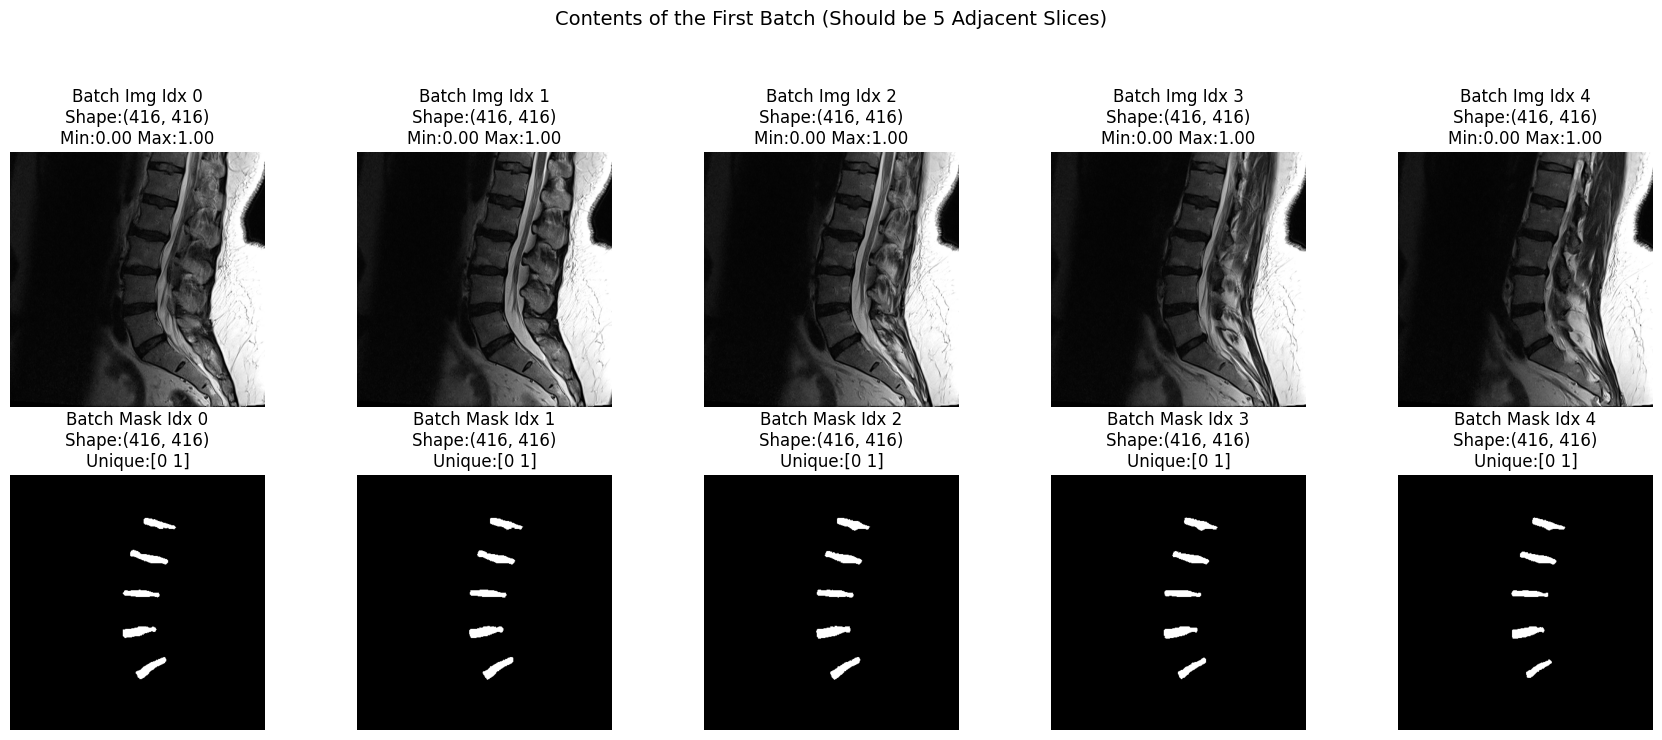

--- End Batch Visualization ---

--- Processing First Batch for Segmentation/Classification ---

--- Processing Sample Batch 1 (5 Slices) from TFRecord ---

Selected middle slice (Index 2) for segmentation:
Shape: (416, 416, 1), DType: float32, Min: 0.0000, Max: 1.0000


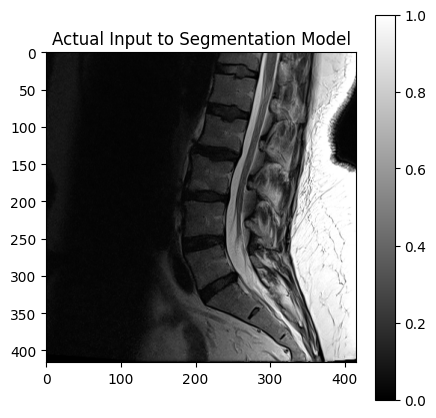

Input shape (1, 416, 416, 1) compatible with model expected shape (None, 416, 416, 1).


I0000 00:00:1745318895.105818   34720 service.cc:148] XLA service 0x7644e0003080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745318895.105838   34720 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-04-22 13:48:15.125561: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745318895.181851   34720 cuda_dnn.cc:529] Loaded cuDNN version 90300


Generated mask shape: (416, 416)
Unique values in generated mask: [0 1], Sum: 4051


I0000 00:00:1745318896.605495   34720 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


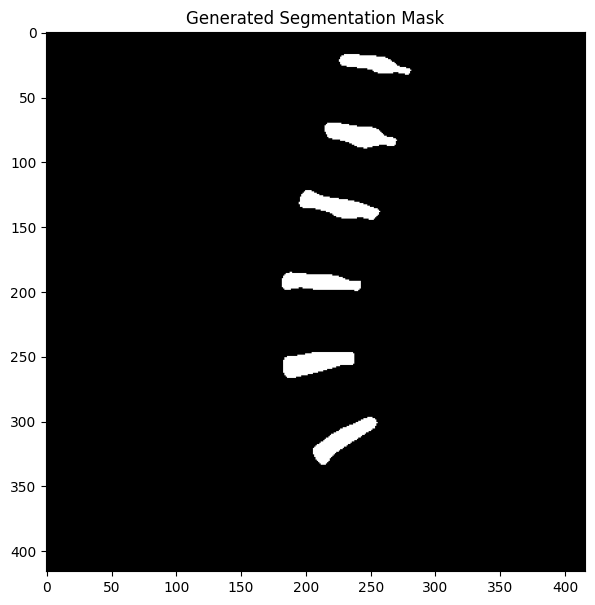


--- Running Classification Preprocessing (extracting 5 patches per disc) ---
find_bounding_boxes_contours: Found 6 raw contours.
    -> Found Box for Contour 0: Area=635 -> (x=203, y=294, w=56, h=43)
    -> Found Box for Contour 1: Area=703 -> (x=180, y=244, w=61, h=26)
    -> Found Box for Contour 2: Area=584 -> (x=179, y=182, w=67, h=21)
    -> Found Box for Contour 3: Area=678 -> (x=192, y=119, w=69, h=29)
    -> Found Box for Contour 4: Area=625 -> (x=212, y=67, w=62, h=26)
    -> Found Box for Contour 5: Area=456 -> (x=223, y=14, w=62, h=22)
Number of discs found and extracted (each with 5 patches): 6


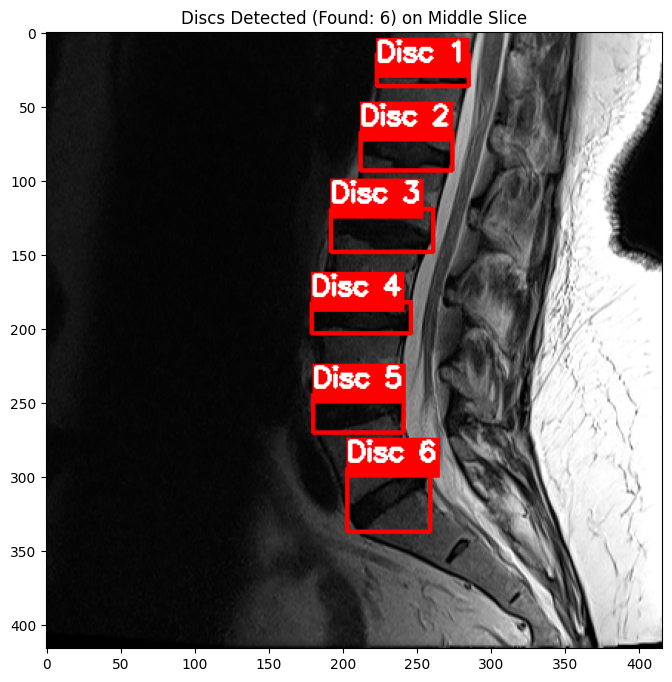


--- Running Classification Prediction for 6 discs ---
Class model loaded.
Raw Predictions: [np.float32(6.0320835e-05), np.float32(0.0016727827), np.float32(0.016910283), np.float32(0.46398303), np.float32(0.15005204), np.float32(0.04200838)]

--- Displaying MIDDLE Extracted Patch for Each Disc ---


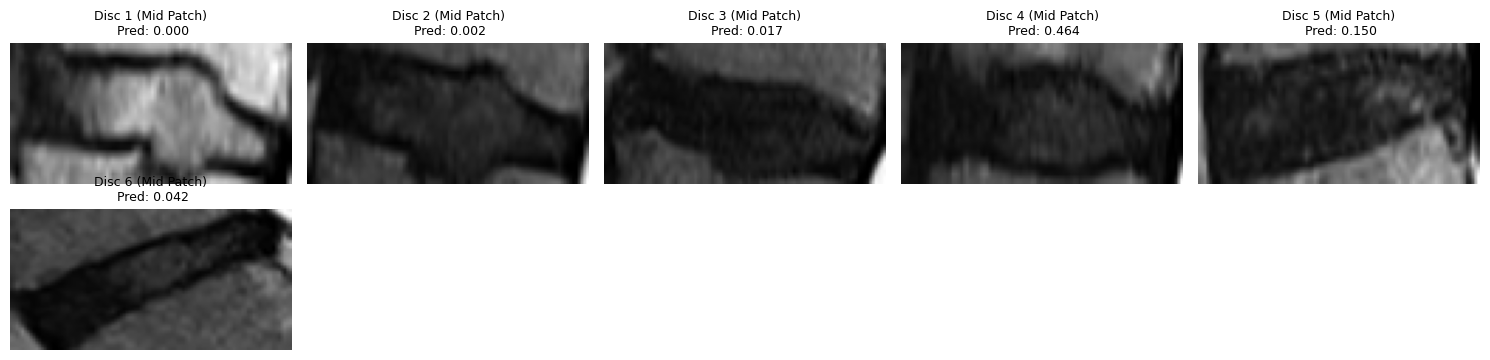


--- Processing Finished for Sample Batch 1 ---


In [ ]:
if segmentation_model is None:
    print("ERROR: Segmentation model was not loaded. Please check Cell 4.")
else:
    if not os.path.isdir(tfrecord_dir):
        print(f"ERROR: TFRecord directory not found at '{tfrecord_dir}'. Please set the path in Cell 3.")
    else:
        try:
            print(f"\n--- Loading data from TFRecords in: {tfrecord_dir} ---")
            tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
            if not tfrecord_files:
                raise FileNotFoundError(f"No .tfrecord files found in {tfrecord_dir}")

            random.shuffle(tfrecord_files)
            print(f"Processing data from randomly selected file: {os.path.basename(tfrecord_files[0])}")
        
            dataset = tf.data.TFRecordDataset(tfrecord_files)

            dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

            dataset = dataset.map(crop_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

            grouped_dataset = dataset.batch(5)

            print("\n--- Visualizing the FIRST Batch (Group of 5 Slices) ---")

            first_batch_to_visualize = grouped_dataset.take(1)

            vis_count = 0
            for batched_images_tensor, batched_masks_tensor in first_batch_to_visualize:
                vis_count += 1
                batch_images_np = batched_images_tensor.numpy()
                batch_masks_np = batched_masks_tensor.numpy()

                print(f"Shape of batched images in this batch: {batch_images_np.shape}")
                print(f"Shape of batched masks in this batch: {batch_masks_np.shape}") 
                print(f"Data type of images: {batch_images_np.dtype}")    
                print(f"Data type of masks: {batch_masks_np.dtype}")     

                num_slices_in_batch = batch_images_np.shape[0]
                if num_slices_in_batch != 5:
                    print(f"Warning: Expected batch size 5, but got {num_slices_in_batch}. Check TFRecord files or pipeline.")

                cols = num_slices_in_batch
                rows = 2 
                plt.figure(figsize=(3.5 * cols, 3.5 * rows)) 

                for i in range(num_slices_in_batch):
                    plt.subplot(rows, cols, i + 1)
                    img_slice = batch_images_np[i, ..., 0] 
                    plt.imshow(img_slice, cmap='gray')
                    plt.title(f"Batch Img Idx {i}\nShape:{img_slice.shape}\nMin:{img_slice.min():.2f} Max:{img_slice.max():.2f}")
                    plt.axis('off')

                    plt.subplot(rows, cols, i + 1 + cols) 
                    mask_slice = batch_masks_np[i, ..., 0] 
                    plt.imshow(mask_slice, cmap='gray')
                    plt.title(f"Batch Mask Idx {i}\nShape:{mask_slice.shape}\nUnique:{np.unique(mask_slice)}")
                    plt.axis('off')

                plt.suptitle("Contents of the First Batch (Should be 5 Adjacent Slices)", y=1.05, fontsize=14)
                plt.tight_layout()
                plt.show()
                break 

            if vis_count == 0:
                 print("WARNING: No batches were produced by the dataset for visualization.")
            print("--- End Batch Visualization ---")

            print("\n--- Processing First Batch for Segmentation/Classification ---")
            example_batch_data = grouped_dataset.take(1) 

            processed_count = 0

            for batched_images_tensor, batched_masks_tensor in example_batch_data:
                processed_count += 1
                print("\n--- Processing Sample Batch 1 (5 Slices) from TFRecord ---")

                processed_stack = batched_images_tensor.numpy()
                ground_truth_stack = batched_masks_tensor.numpy() 

                middle_slice_index = 2 
                if processed_stack.shape[0] != 5:
                     raise ValueError(f"Processing error: Expected 5 slices in the batch, but got {processed_stack.shape[0]}")
                middle_preprocessed_slice = processed_stack[middle_slice_index, :, :, :]

                print(f"\nSelected middle slice (Index {middle_slice_index}) for segmentation:")
                print(f"Shape: {middle_preprocessed_slice.shape}, DType: {middle_preprocessed_slice.dtype}, Min: {middle_preprocessed_slice.min():.4f}, Max: {middle_preprocessed_slice.max():.4f}")
                plt.figure(figsize=(5,5))
                plt.imshow(middle_preprocessed_slice.squeeze(), cmap='gray')
                plt.title("Actual Input to Segmentation Model")
                plt.colorbar()
                plt.show()

                generated_mask = generate_mask(middle_preprocessed_slice, segmentation_model)

                print(f"Generated mask shape: {generated_mask.shape}")
                print(f"Unique values in generated mask: {np.unique(generated_mask)}, Sum: {np.sum(generated_mask)}")
                plt.figure(figsize=(7, 7)); plt.imshow(generated_mask, cmap='gray'); plt.title("Generated Segmentation Mask"); plt.show()

                print("\n--- Running Classification Preprocessing (extracting 5 patches per disc) ---")
                list_of_5_patch_sets, bounding_box_image = classification_preprocessing_5slices(processed_stack, generated_mask)
                num_discs_found = len(list_of_5_patch_sets)
                print(f"Number of discs found and extracted (each with 5 patches): {num_discs_found}")
                plt.figure(figsize=(8, 8)); plt.imshow(cv2.cvtColor(bounding_box_image, cv2.COLOR_BGR2RGB)); plt.title(f"Discs Detected (Found: {num_discs_found}) on Middle Slice"); plt.show()

                if num_discs_found > 0:
                    num_discs_to_process = len(list_of_5_patch_sets)
                    print(f"\n--- Running Classification Prediction for {num_discs_to_process} discs ---")
                    predictions, middle_patches = predict_label_5slices(classification_model_path, list_of_5_patch_sets)
                    print(f"Raw Predictions: {predictions}")
                    print("\n--- Displaying MIDDLE Extracted Patch for Each Disc ---")
                    cols=5; rows=(num_discs_to_process+cols-1)//cols; plt.figure(figsize=(3*cols, 1.5*rows*1.2))
                    for i, patch in enumerate(middle_patches):
                        plt.subplot(rows, cols, i + 1); plt.imshow(patch, cmap='gray')
                        pred_score = predictions[i] if i < len(predictions) else float('nan')
                        plt.title(f"Disc {i+1} (Mid Patch)\n Pred: {pred_score:.3f}", fontsize=9); plt.axis('off')
                    plt.tight_layout(); plt.show()
                else: print("\nNo discs found, skipping classification prediction.")

                print("\n--- Processing Finished for Sample Batch 1 ---")
                break 

            if processed_count == 0: print("ERROR: No batches could be loaded from the TFRecord dataset for processing.")

        except Exception as e:
            print(f"\n--- An Error Occurred During Processing ---")
            print(f"Error Type: {type(e).__name__}"); print(f"Error Message: {e}")
            print("Traceback:"); print(traceback.format_exc())